In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data
from data import DURATION, WIDTH, HEIGHT
import GPy
from GPy.models import GPRegression
from numpy import ndarray


In [2]:
input_field_names = ["psl", "uas", "vas", "pr", "sfcWind"]
d = len(input_field_names)
input_fields = [data.load_field(name)[1] for name in input_field_names]
all_inputs = np.stack([f.values for f in input_fields], axis=4)
all_inputs = all_inputs.reshape(DURATION, HEIGHT, WIDTH, d)

def field_d(name: str) -> int:
    """Returns the dimension in the input tensor containing the given field."""
    return input_field_names.index(name)

_, wsgsmax_field = data.load_field("wsgsmax")
all_wsgsmax = wsgsmax_field.values.reshape(DURATION, HEIGHT, WIDTH)

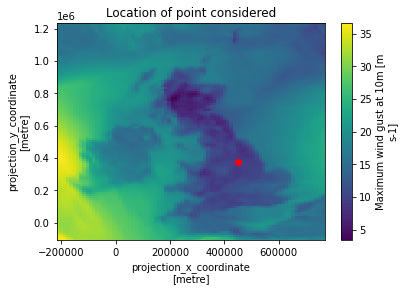

In [3]:
train_start = 500
train_length = 1080
val_length = 1080
test_length = 1080
val_start = train_start + train_length
test_start = val_start + val_length
train_time = np.arange(train_start, train_start + train_length, 1)
val_time = np.arange(val_start, val_start + val_length, 1)
test_time = np.arange(test_start, test_start + test_length + test_length, 1)
x = 55
y = 40

train_inputs = all_inputs[train_time, y, x, :]
train_wsgsmax = all_wsgsmax[train_time, y, x]
val_inputs = all_inputs[val_time, y, x, :]
val_wsgsmax = all_wsgsmax[val_time, y, x]
test_inputs = all_inputs[test_time, y, x, :]
test_wsgsmax = all_wsgsmax[test_time, y, x]

wsgsmax_field[0,0].plot()
plt.title("Location of point considered")
plt.scatter([wsgsmax_field.projection_x_coordinate[x]], [wsgsmax_field.projection_y_coordinate[y]], color="red")
plt.show()

17.334094429016112


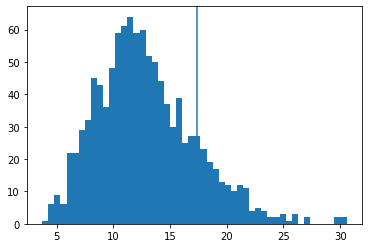

In [4]:
# Take a look at what extreme values of wsgsmax look like, in our area and timeframe
plt.hist(train_wsgsmax.reshape(-1), bins=50)
percentile = np.percentile(train_wsgsmax, 85)
print(percentile)
plt.axvline(percentile)
plt.show()

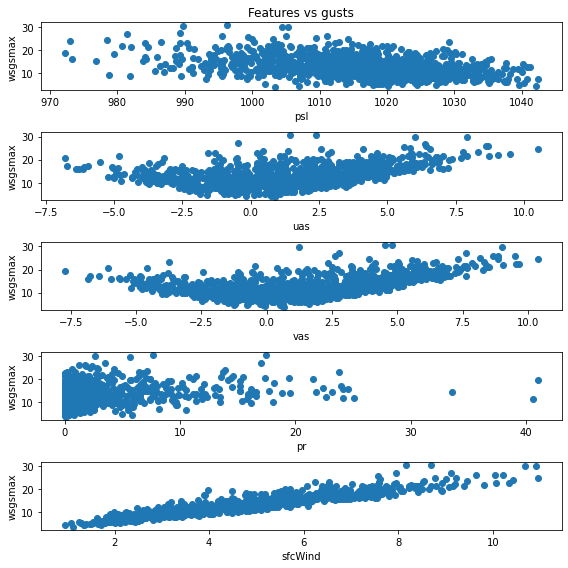

In [5]:
fig, axes = plt.subplots(len(input_field_names), figsize=(8,8))
for i, (name, ax) in enumerate(zip(input_field_names, axes)):
    ax.scatter(train_inputs[:, i], train_wsgsmax)
    ax.set_ylabel("wsgsmax")
    ax.set_xlabel(name)
axes[0].set_title("Features vs gusts")
plt.tight_layout()
plt.show()

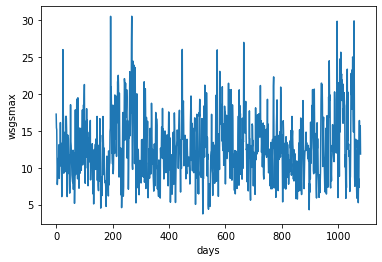

In [6]:
plt.plot(range(train_wsgsmax.shape[0]), train_wsgsmax)
plt.xlabel("days")
plt.ylabel("wsgsmax")
plt.show()

In [7]:
def mse(preds: ndarray, targets: ndarray) -> float:
    return ((preds.reshape(-1) - targets.reshape(-1)) ** 2).mean().item()

def evaluate(model: GPRegression, plot=True):
    # We consider MSE for all points, and MSE for "extreme" gusts
    # The hope is that considering the "extreme" gusts will help us hit the peaks
    extreme_gust_speed = 17
    means, vars = model.predict(val_inputs)

    all_mse = mse(means, val_wsgsmax)

    extreme_indices = val_wsgsmax > extreme_gust_speed
    extreme_mse = mse(means[extreme_indices], val_wsgsmax[extreme_indices])
    if plot:
        plot_eval(model)
    return all_mse, extreme_mse

def plot_eval(model: GPRegression, n=100):
    short_test = test_inputs[0:n]
    short_targets = test_wsgsmax[0:n]
    plt.plot(range(short_test.shape[0]), short_targets, label="truth")
    preds = model.predict(short_test)
    plt.plot(range(short_test.shape[0]), preds[0].reshape(-1), label="preds")
    plt.xlabel("days")
    plt.ylabel("wsgsmax")
    plt.title("Results on validation set")
    plt.legend()
    plt.show()

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0001   3.768496e+03   8.841851e+05 
    02s37  0018   2.062111e+03   1.382524e+00 
    03s11  0024   2.062041e+03   1.351247e-06 
Runtime:     03s11
Optimization status: Converged



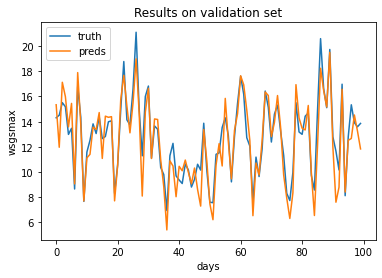

(3.1389911270484414, 8.466068375758875)

In [8]:
# Very first attempt
kernels = [
    GPy.kern.Linear(input_dim=1, active_dims=[field_d("psl")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("uas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("vas")]),
    GPy.kern.Linear(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel * k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel)
model.optimize(messages=True)
evaluate(model)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s11  0002   2.330897e+03   5.470229e+04  /home/oscar/nobackup/apps/miniconda3/envs/wind/lib/python3.8/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 5. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
    00s19  0004   2.206369e+03   2.974313e+03 
    00s83  0022   2.185965e+03   4.378941e-07 
Runtime:     00s83
Optimization status: Converged



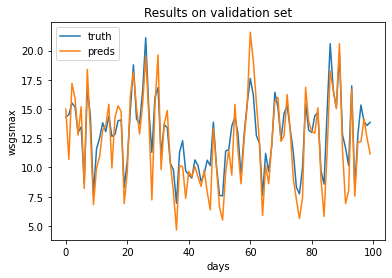

(4.03409310993639, 8.994416557641378)

In [9]:
# Try just a linear model on sfcWind
kernels = [
    GPy.kern.Linear(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel * k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel)
model.optimize(messages=True)
evaluate(model)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s18  0001   4.382344e+03   1.027338e+06 
    02s32  0017   3.430924e+03   4.408659e+05 
    03s71  0028   2.327719e+03   1.670014e-08 
Runtime:     03s71
Optimization status: Converged



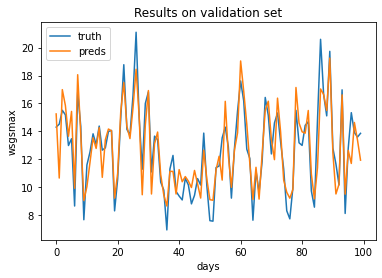

(4.5115229980648515, 12.012124075791798)

In [10]:
# Try with a slightly smarter mean: sustained wind speed + the mean additional gust
mean_add_gust = (train_wsgsmax - train_inputs[:, field_d("sfcWind")]).mean()
mf = GPy.core.Mapping(train_inputs.shape[1], 1)
mf.f = lambda x: (x[:, field_d("sfcWind")] + mean_add_gust).reshape(-1, 1)
mf.update_gradients = lambda a,b: None

kernels = [
    GPy.kern.Linear(input_dim=1, active_dims=[field_d("psl")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("uas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("vas")]),
    GPy.kern.Linear(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel * k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel, mean_function=mf)
model.optimize(messages=True)
evaluate(model)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.904939e+03           nan 
    03s09  0017   2.063573e+03   3.573381e+03 
    06s21  0035   1.971399e+03   1.390547e-01 
    10s39  0059   2.487651e+03   6.624995e+05 
    11s43  0065   1.964904e+03   4.753531e-05 
    11s95  0068   1.964904e+03   7.483838e-06 
Runtime:     11s95
Optimization status: Converged



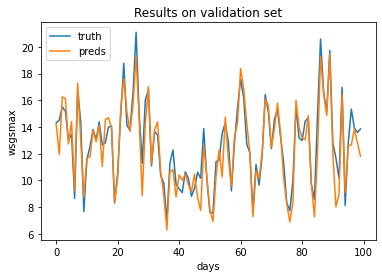

(2.595426079101845, 7.1099148107797125)

In [11]:
# Smarter mean, but use RBF for all kernels
mean_add_gust = (train_wsgsmax - train_inputs[:, field_d("sfcWind")]).mean()
mf = GPy.core.Mapping(train_inputs.shape[1], 1)
mf.f = lambda x: (x[:, field_d("sfcWind")] + mean_add_gust).reshape(-1, 1)
mf.update_gradients = lambda a,b: None

kernels = [
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("psl")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("uas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("vas")]),
    GPy.kern.RBF(input_dim=1, active_dims=[field_d("sfcWind")]),
]
kernel = kernels[0]
for k in kernels[1:]:
    kernel = kernel * k
model = GPRegression(train_inputs, train_wsgsmax.reshape(-1, 1), kernel, mean_function=mf)
model.optimize(messages=True)
evaluate(model)